In [1]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import regex as re
import random
import nltk
import multiprocessing
import umap.umap_ as umap
import umap.plot
import re
import string
import warnings
import torch

from sklearn.metrics import roc_curve, auc, mean_squared_error
from surprise import Reader, Dataset, accuracy
from surprise.prediction_algorithms.knns import KNNWithMeans
from surprise.model_selection import cross_validate, KFold, train_test_split
from surprise.prediction_algorithms.matrix_factorization import NMF, SVD
import pandas as pd

L = pd.read_csv("Synthetic_Movie_Lens/links.csv")
M = pd.read_csv("Synthetic_Movie_Lens/movies.csv")
R = pd.read_csv("Synthetic_Movie_Lens/ratings.csv")
T = pd.read_csv("Synthetic_Movie_Lens/tags.csv")

from surprise import KNNWithMeans, NMF, SVD
from sklearn.metrics import roc_curve, auc

# Reader for surprise library
reader = Reader(rating_scale=(0.5, 5))

# Load your dataset in the surprise dataset format
data = Dataset.load_from_df(R[['userId', 'movieId', 'rating']], reader)

# Train-Test split
trainset, testset = train_test_split(data, test_size=.25)

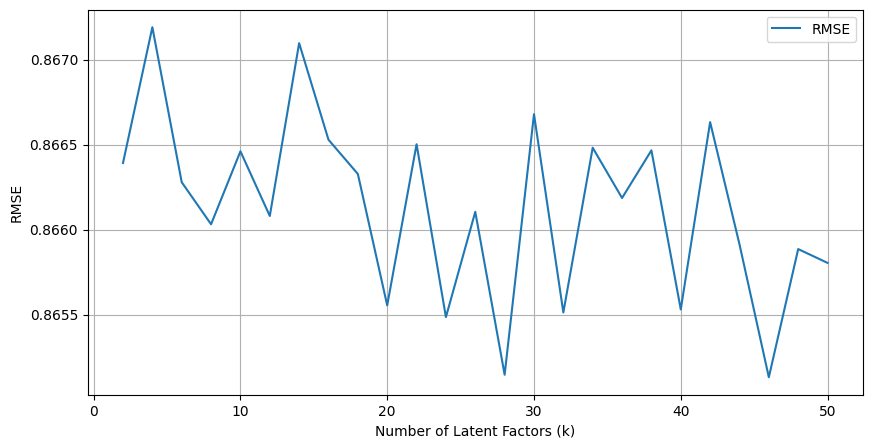

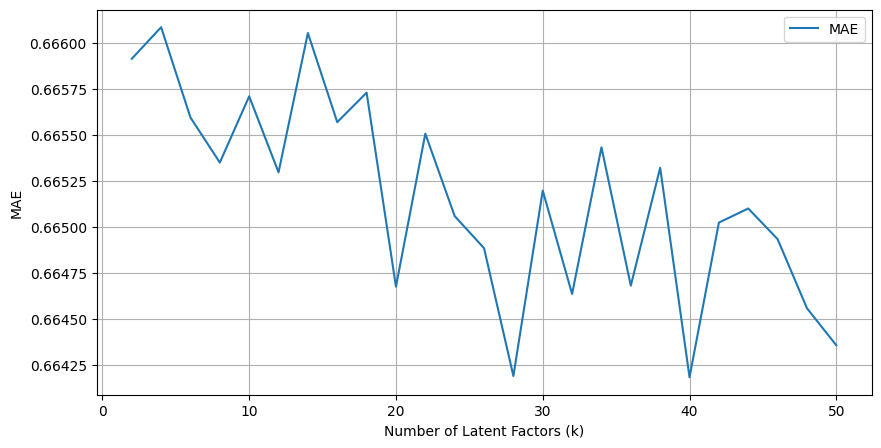

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from surprise import SVD, Dataset, Reader
from surprise.model_selection import cross_validate, train_test_split

# Your data loading code here...

reader = Reader(rating_scale=(0.5, 5))
data = Dataset.load_from_df(R[['userId', 'movieId', 'rating']], reader)

rmse_scores = []
mae_scores = []

k_values = list(range(2, 51, 2))

# Use SVD algorithm to create collaborative filter and compute RMSE and MAE
for k in k_values:
    algo = SVD(n_factors=k)
    cv_results = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=10, verbose=False)
    
    rmse_scores.append(np.mean(cv_results['test_rmse']))
    mae_scores.append(np.mean(cv_results['test_mae']))

# Plot RMSE scores
plt.figure(figsize=(10, 5))
plt.plot(k_values, rmse_scores, label='RMSE')
plt.xlabel('Number of Latent Factors (k)')
plt.ylabel('RMSE')
plt.legend()
plt.grid()
plt.show()

# Plot MAE scores
plt.figure(figsize=(10, 5))
plt.plot(k_values, mae_scores, label='MAE')
plt.xlabel('Number of Latent Factors (k)')
plt.ylabel('MAE')
plt.legend()
plt.grid()
plt.show()


In [3]:
# Optimal number of latent factors is 4 for both
grouped = R.groupby('movieId')['rating']

# Get the number of ratings and the variance of ratings for each movie.
rating_counts = grouped.count()
rating_variances = grouped.var()

# Define your subsets.
popular_movies = rating_counts[rating_counts > 2].index
unpopular_movies = rating_counts[rating_counts <= 2].index
high_variance_movies = rating_counts[(rating_counts >= 5) & (rating_variances >= 2)].index

# Trim your ratings data to create the subsets.
popular_ratings = R[R['movieId'].isin(popular_movies)]
unpopular_ratings = R[R['movieId'].isin(unpopular_movies)]
high_variance_ratings = R[R['movieId'].isin(high_variance_movies)]

Minimum average RMSE for Popular Movies: 0.8555363173473347 at k=46


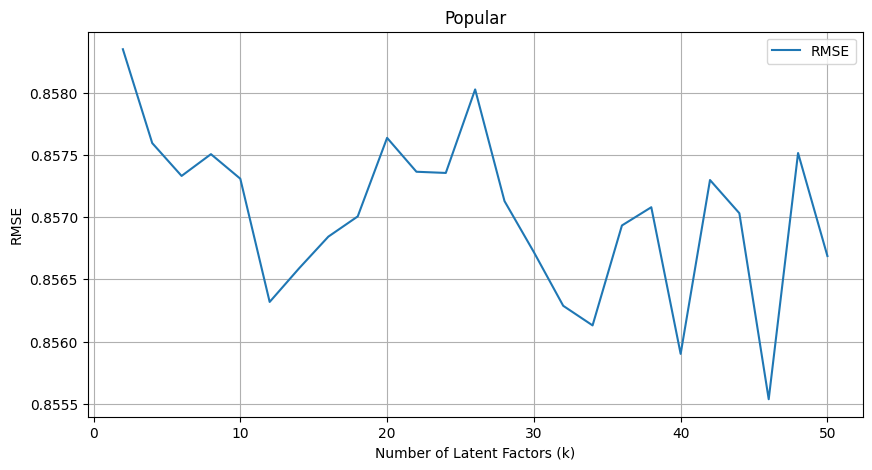

Minimum average RMSE for Unpopular Movies: 0.8941188807016532 at k=4


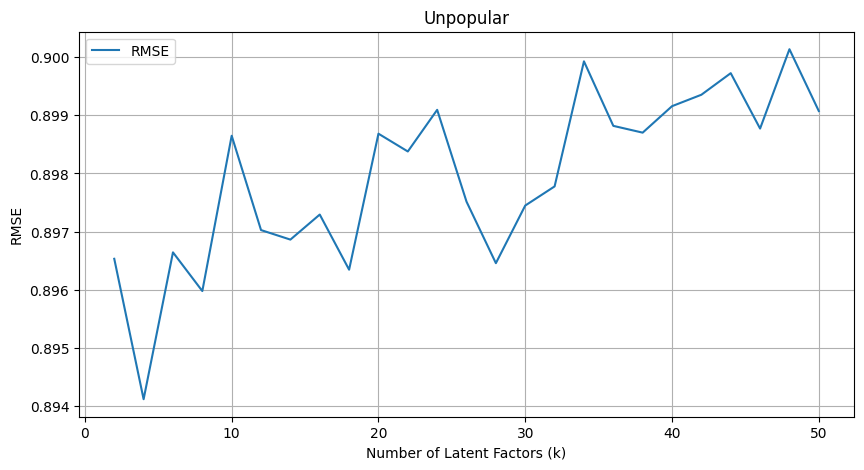

Minimum average RMSE for High Variance Movies: 1.4119556877515531 at k=18


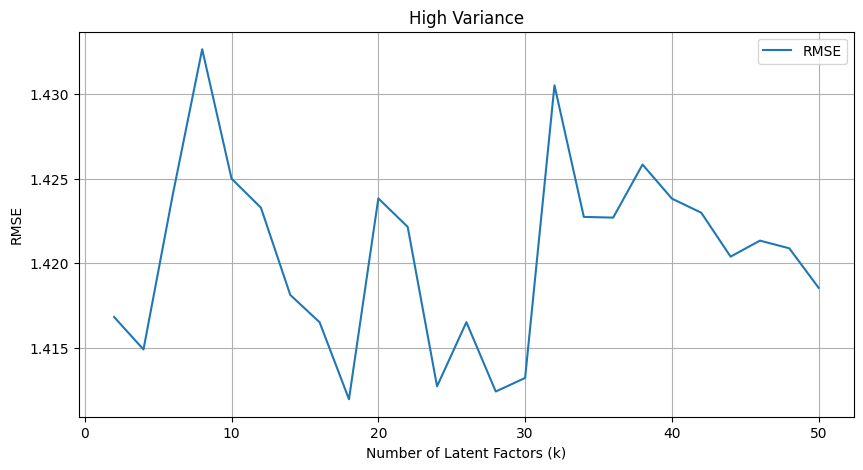

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from surprise import SVD, Dataset, Reader
from surprise.model_selection import cross_validate

# Define a function to perform cross validation for a given dataset and plot the RMSE
def cross_validate_and_plot(data, title):
    rmse_scores = []
    k_values = list(range(2, 51, 2))

    for k in k_values:
        algo = SVD(n_factors=k)
        cv_results = cross_validate(algo, data, measures=['RMSE'], cv=10, verbose=False)
        rmse_scores.append(np.mean(cv_results['test_rmse']))
    
    min_rmse_k = k_values[rmse_scores.index(min(rmse_scores))]
    print(f'Minimum average RMSE for {title} Movies: {min(rmse_scores)} at k={min_rmse_k}')

    plt.figure(figsize=(10, 5))
    plt.plot(k_values, rmse_scores, label='RMSE')
    plt.title(title)
    plt.xlabel('Number of Latent Factors (k)')
    plt.ylabel('RMSE')
    plt.legend()
    plt.grid()
    plt.show()

# Load your subsets in the surprise dataset format
popular_data = Dataset.load_from_df(popular_ratings[['userId', 'movieId', 'rating']], reader)
unpopular_data = Dataset.load_from_df(unpopular_ratings[['userId', 'movieId', 'rating']], reader)
high_variance_data = Dataset.load_from_df(high_variance_ratings[['userId', 'movieId', 'rating']], reader)

# Cross validate and plot for each subset
cross_validate_and_plot(popular_data, 'Popular')
cross_validate_and_plot(unpopular_data, 'Unpopular')
cross_validate_and_plot(high_variance_data, 'High Variance')


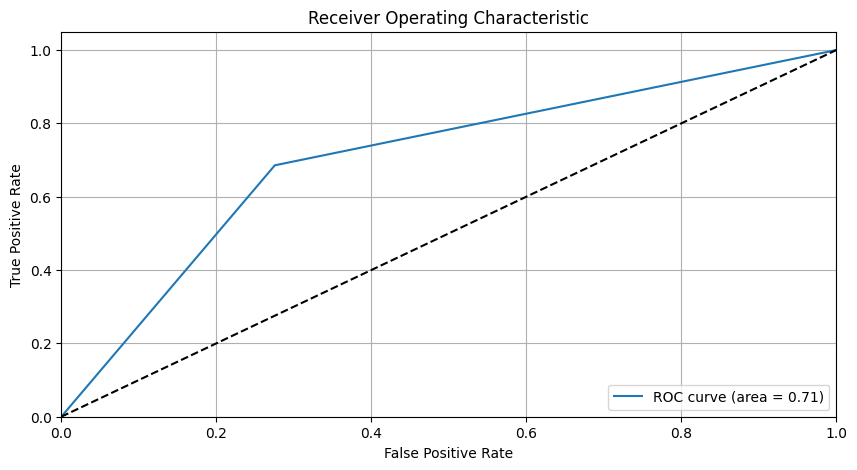

In [8]:
# Choose your k value. Here, let's use the value that resulted in the minimum average RMSE in the earlier step.
k = 10

algo = SVD(n_factors=k)

# Perform a train-test split
trainset, testset = train_test_split(data, test_size=.25)
algo.fit(trainset)

# Perform the prediction
predictions = algo.test(testset)

# Convert the true ratings into binary format
true_bin = [1 if rating >= 3.5 else 0 for rating in np.array([pred.r_ui for pred in predictions])]

# Use the predicted ratings as scores
scores = np.array([pred.est for pred in predictions])

# Compute false positive rate, true positive rate
fpr, tpr, _ = roc_curve(true_bin, scores)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10, 5))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.grid()
plt.show()



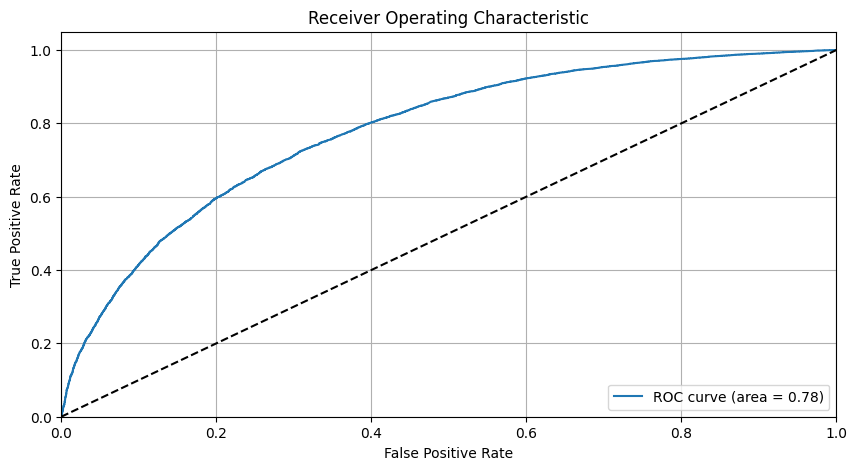

In [9]:
from surprise import accuracy
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Choose your k value. Here, let's use the value that resulted in the minimum average RMSE in the earlier step.
k = 10

algo = SVD(n_factors=k)

# Perform a train-test split
trainset, testset = train_test_split(data, test_size=.25)
algo.fit(trainset)

# Perform the prediction
predictions = algo.test(testset)

# Convert the true ratings into binary format
true_bin = [1 if rating >= 3.5 else 0 for rating in np.array([pred.r_ui for pred in predictions])]

# Get the predicted ratings directly
pred = np.array([pred.est for pred in predictions])

# Compute false positive rate, true positive rate
fpr, tpr, _ = roc_curve(true_bin, pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10, 5))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.grid()
plt.show()
